# Comparing algorithms on the Kddchurn dataset
The data is taken from [this source](http://www.kdd.org/kdd-cup/view/kdd-cup-2009/Data).

For details on running the comparison, see [this article](https://github.com/catboost/benchmarks/blob/master/comparison_description.pdf).

In [2]:
from experiment import Experiment
from xgboost_experiment import XGBExperiment
from lightgbm_experiment import LGBExperiment
from catboost_experiment import CABExperiment

Load the dataset and set parameters for the experiment.

In [3]:
learning_task = 'classification'
dataset_path = '/media/pool_storage/tsnet-pools-converted/kddchurn/'
n_estimators = 5000
max_hyperopt_evals = 50

experiment = Experiment(learning_task, train_path=dataset_path + 'train_full3',
                        test_path=dataset_path + 'test3', cd_path = dataset_path + 'train_full3.cd')
X_train, y_train, X_test, y_test, cat_cols = experiment.read_data()

Write a function that does the following:

**Preprocess the dataset:**
calculate counter values on the training set, transform cat features (for the `XGBoost` and `LightGBM` algorithms), and convert the data to the format of the algorithm. Do the same thing with all pairs after splitting them into cross validation folds.

**Select the optimal number of trees for the algorithm with the default parameters:** for each fold and each number of trees, get the result of the algorithm trained on the other four folds, average the results for each number of trees, and choose the best one. 

**Assess the quality of the algorithm with the default parameters on a test dataset:** train the algorithm with the number of trees obtained in the previous step, and calculate the metric value on the test dataset.

**Tune parameters for the algorithm using `Hyperopt`:** on each `Hyperopt` iteration of the algorithm, the best value of trees is selected and the metric for cross validation is calculated.

**Show results on the test dataset for the algorithm with the tuned parameters:** train the algorithm with the optimal parameters and the number of trees obtained in the previous step, and calculate the metric value on the test dataset.

In [4]:
import numpy as np

def run_experiment(Experiment, title):
    experiment = Experiment(learning_task, max_hyperopt_evals=max_hyperopt_evals,
                            n_estimators=n_estimators)
    cv_pairs, (dtrain, dtest) = experiment.split_and_preprocess(X_train.copy(), y_train, 
                                                                X_test.copy(), y_test, 
                                                                cat_cols, n_splits=5)
 
    default_cv_result = experiment.run_cv(cv_pairs)
    experiment.print_result(default_cv_result, 'Default {} result on cv'.format(title))

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')

    default_test_losses = []
    for seed in range(5):
        test_result = experiment.run_test(dtrain, dtest, X_test, params=default_cv_result['params'],
                                          n_estimators=default_cv_result['best_n_estimators'], seed=seed)
        default_test_losses.append(test_result['loss'])
        print 'For seed=%d Test\'s %s : %.5f' % (seed, experiment.metric, default_test_losses[-1])
    print '\nTest\'s %s mean: %.5f, Test\'s %s std: %.5f' % (experiment.metric, np.mean(default_test_losses),
                                                             experiment.metric, np.std(default_test_losses))

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')
    print('Hyperopt iterations:\n\n')

    tuned_cv_result = experiment.optimize_params(cv_pairs)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')

    experiment.print_result(tuned_cv_result, 'Tuned {} result on cv'.format(title))

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')

    tuned_test_losses = []
    for seed in range(5):
        test_result = experiment.run_test(dtrain, dtest, X_test, params=tuned_cv_result['params'],
                                          n_estimators=tuned_cv_result['best_n_estimators'], seed=seed)
        tuned_test_losses.append(test_result['loss'])
        print 'For seed=%d Test\'s %s : %.5f' % (seed, experiment.metric, tuned_test_losses[-1])
    print '\nTest\'s %s mean: %.5f, Test\'s %s std: %.5f' % (experiment.metric, np.mean(tuned_test_losses),
                                                             experiment.metric, np.std(tuned_test_losses))

    return np.mean(default_test_losses), np.mean(tuned_test_losses)

## `XGBoost`

In [7]:
xgb_default_test_result, xgb_tuned_test_result = run_experiment(XGBExperiment, "XGBoost")

Default XGBoost result on cv:

logloss = 0.24202
best_n_estimators = 13
params = {'colsample_bytree': 1.0, 'silent': 1, 'eval_metric': 'logloss', 'colsample_bylevel': 1.0, 'min_child_weight': 1, 'subsample': 1.0, 'eta': 0.3, 'objective': 'binary:logistic', 'alpha': 0, 'seed': 0, 'max_depth': 6, 'gamma': 0, 'lambda': 1}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Default XGBoost result on test:

For seed=0 Test's logloss : 0.233693
For seed=1 Test's logloss : 0.233693
For seed=2 Test's logloss : 0.233693
For seed=3 Test's logloss : 0.233693
For seed=4 Test's logloss : 0.233693

Test's logloss mean: 0.233693, Test's logloss std: 0.000000

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Hyperopt iterations:

[1/50]	eval_time=985.40 sec	current_logloss=0.236414	min_logloss=0.236414
[2/50]	eval_time=1206.43 sec	current_logloss=0.238277	min_logloss=0.236414
[3/50]	eval_time=537.17 sec	current_logloss=0.257735	min_logloss=0.236414
[4/50]	eval_time=521.10 sec	current_logloss=0

## `LightGBM`

In [8]:
lgb_default_test_result, lgb_tuned_test_result = run_experiment(LGBExperiment, "LightGBM")

Default LightGBM result on cv:

logloss = 0.239539085623
best_n_estimators = 49
params = {'feature_fraction_seed': 0, 'num_leaves': 127, 'verbose': -1, 'bagging_seed': 0, 'lambda_l1': 0, 'drop_seed': 0, 'learning_rate': 0.1, 'lambda_l2': 0, 'data_random_seed': 0, 'bagging_fraction': 1.0, 'min_data_in_leaf': 100, 'max_bin': 255, 'objective': 'binary', 'bagging_freq': 1, 'metric': 'binary_logloss', 'min_sum_hessian_in_leaf': 10, 'feature_fraction': 1.0}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Default LightGBM result on test:

For seed=0 Test's logloss : 0.235649
For seed=1 Test's logloss : 0.235649
For seed=2 Test's logloss : 0.235649
For seed=3 Test's logloss : 0.235649
For seed=4 Test's logloss : 0.235649

Test's logloss mean: 0.235649, Test's logloss std: 0.000000

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Hyperopt iterations:

[1/50]	eval_time=399.73 sec	current_logloss=0.239068	min_logloss=0.239068
[2/50]	eval_time=156.73 sec	current_logloss=0.237651	min_l

## `CatBoost`

In [9]:
cab_default_test_result, cab_tuned_test_result = run_experiment(CABExperiment, "CatBoost")

Default CatBoost result on cv:

logloss = 0.2334729811
best_n_estimators = 1347
params = {'rsm': 1.0, 'iterations': 1347, 'random_seed': 4, 'verbose': False, 'thread_count': 16, 'learning_rate': 0.03, 'ctr_description': ['Borders', 'CounterMax'], 'depth': 6, 'fold_len_multiplier': 2, 'loss_function': 'Logloss', 'ctr_border_count': 16, 'l2_leaf_reg': 3, 'leaf_estimation_method': 'Newton', 'gradient_iterations': 10, 'border_count': 128, 'used_ram_limit': 100000000000}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Default CatBoost result on test:

For seed=0 Test's logloss : 0.232270
For seed=1 Test's logloss : 0.231504
For seed=2 Test's logloss : 0.231413
For seed=3 Test's logloss : 0.231987
For seed=4 Test's logloss : 0.232500

Test's logloss mean: 0.231935, Test's logloss std: 0.000422

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Hyperopt iterations:

[1/50]	eval_time=2348.19 sec	current_logloss=0.233691	min_logloss=0.233691
[2/50]	eval_time=3029.39 sec	current_loglo

## Comparing results

The final table with metric values on the test dataset.

Populating the interactive namespace from numpy and matplotlib


,default,tuned
xgboost,0.233693 (+1.04%),0.233123 (+0.79%)
lightgbm,0.235649 (+1.88%),0.232049 (+0.33%)
catboost,0.231935 (+0.28%),0.231289 (+0.00%)


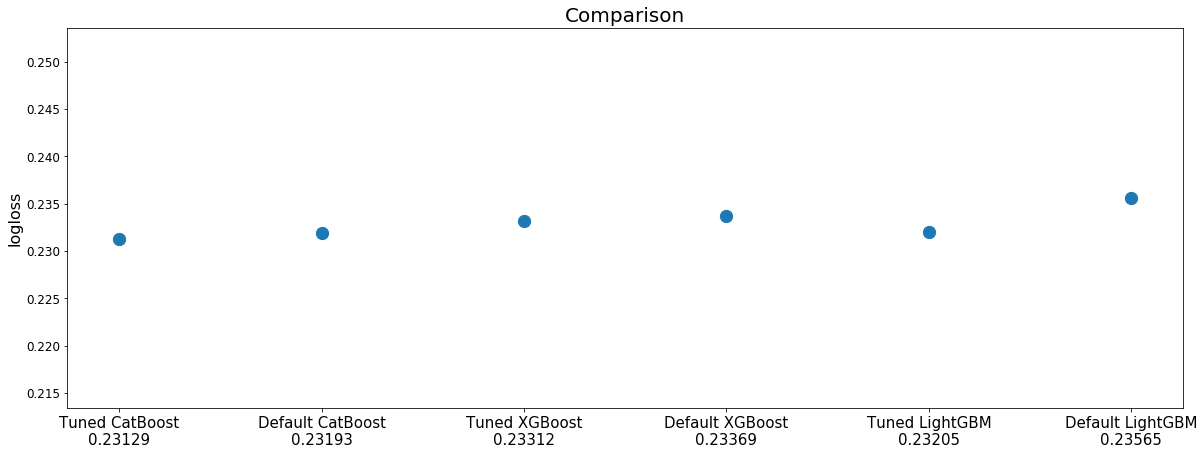

In [11]:
import pandas as pd
import numpy as np
from IPython.display import HTML, display
%pylab inline --no-import-all

test_results = np.array([
    (xgb_default_test_result, xgb_tuned_test_result),
    (lgb_default_test_result, lgb_tuned_test_result),
    (cab_default_test_result, cab_tuned_test_result)
])

diff = 100 * test_results / test_results[2,1] - 100

res = [['{:.6f} ({:+.2f}%)'.format(test_results[i, j], diff[i, j]) for j in range(2)] for i in range(3)]

display(HTML(pd.DataFrame(res, columns=['default', 'tuned'], index=['xgboost', 'lightgbm', 'catboost']).to_html()))

results = [
    ('Tuned CatBoost',   cab_tuned_test_result),
    ('Default CatBoost', cab_default_test_result),
    ('Tuned XGBoost',    xgb_tuned_test_result),
    ('Default XGBoost',  xgb_default_test_result),
    ('Tuned LightGBM',   lgb_tuned_test_result),
    ('Default LightGBM', lgb_default_test_result),
]
names = ['%s\n%.5f' % (name, loss) for name, loss in results]

plt.figure(figsize=(20, 7))
plt.scatter(range(6), zip(*results)[1], s=150)
plt.xticks(range(6), names, fontsize=15)
plt.yticks(fontsize=12)
plt.title('Comparison', fontsize=20)
plt.ylabel(experiment.metric, fontsize=16);